# Galaxy Rotation Curve Simulation

This notebook simulates the rotation curve of a spiral galaxy using a combination of disk and spherical halo components. We'll use representative parameters for a Milky-way like galaxy and handle all units using `astropy.units`.

## Import Required Libraries

Import the necessary libraries for our simulation:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from scipy import special

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

# Set plot style
#plt.style.use('seaborn')
%matplotlib inline

## Define Constants and Parameters

We'll define the parameters for a Milky-way like galaxy:
- Disk parameters: mass and scale length
- Halo parameters: density profile and scale radius

In [18]:
# Disk parameters (typical values for Milky Way-like galaxy)
disk_mass = 5e10 * u.M_sun  # Total disk mass
disk_scale_length = 3.5 * u.kpc  # Disk scale length

# Dark matter halo parameters (NFW profile)
halo_scale_radius = 20.0 * u.kpc  # Scale radius
halo_characteristic_density = 1e7 * u.M_sun / u.kpc**3  # Characteristic density

# Radial range for calculations
r = np.linspace(0.1, 30, 1000) * u.kpc  # From 0.1 to 30 kpc

## Implement Disk Component

For the disk component, we'll use an exponential disk model. The rotation velocity at radius r is given by:
$v_c(r) = \sqrt{\frac{GM(r)}{r}}$
where M(r) is the mass enclosed within radius r for an exponential disk.

In [19]:
def disk_rotation_curve(r, mass, scale_length):
    """
    Calculate the rotation curve for an exponential disk.
    
    Parameters
    ----------
    r : astropy.units.Quantity
        Array of radii at which to calculate the rotation curve
    mass : astropy.units.Quantity
        Total mass of the disk
    scale_length : astropy.units.Quantity
        Scale length of the exponential disk
        
    Returns
    -------
    astropy.units.Quantity
        Array of rotation velocities at the given radii
    """
    # Normalize radius
    x = (r / (2 * scale_length)).decompose()
    
    # Handle small radii to avoid numerical issues
    v = np.zeros_like(r.value) * u.km / u.s
    mask = x.value > 0
    
    # For non-zero radii, calculate using Bessel functions
    # Formula from Binney & Tremaine (2008), eq. 2.165
    x_calc = x.value[mask]
    
    # Calculate term with Bessel functions
    bessel_term = (x_calc * 
                  (special.iv(0, x_calc) * special.kv(0, x_calc) - 
                   special.iv(1, x_calc) * special.kv(1, x_calc)))
    
    # Calculate velocity using the complete formula
    v_squared = ((const.G * mass / scale_length) * 
                 2 * x_calc * bessel_term).to(u.km**2 / u.s**2)
    
    v[mask] = np.sqrt(v_squared)
    
    return v

# Calculate disk rotation curve
v_disk = disk_rotation_curve(r, disk_mass, disk_scale_length)

## Implement Halo Component

For the dark matter halo, we'll use the NFW (Navarro-Frenk-White) profile. The rotation velocity is given by:
$v_c(r) = \sqrt{\frac{GM(r)}{r}}$
where M(r) is the mass enclosed within radius r for an NFW profile.

In [20]:
def halo_rotation_curve(r, rho_s, r_s):
    """
    Calculate the rotation curve for an NFW dark matter halo.
    
    Parameters
    ----------
    r : astropy.units.Quantity
        Array of radii at which to calculate the rotation curve
    rho_s : astropy.units.Quantity
        Characteristic density of the NFW profile
    r_s : astropy.units.Quantity
        Scale radius of the NFW profile
        
    Returns
    -------
    astropy.units.Quantity
        Array of rotation velocities at the given radii
    """
    # Calculate x = r/r_s
    x = (r / r_s).decompose()
    
    # Calculate the circular velocity
    v_squared = (4 * np.pi * const.G * rho_s * r_s**3 / r * 
                (np.log(1 + x) - x/(1 + x))).to(u.km**2 / u.s**2)
    
    return np.sqrt(v_squared.value) * u.km / u.s

# Calculate halo rotation curve
v_halo = halo_rotation_curve(r, halo_characteristic_density, halo_scale_radius)

## Calculate Total Rotation Curve

The total rotation curve is calculated by adding the contributions from the disk and halo components in quadrature:
$v_{total}^2 = v_{disk}^2 + v_{halo}^2$

In [21]:
# Calculate total rotation curve
v_total = np.sqrt(v_disk**2 + v_halo**2)

## Plot Rotation Curve

Create a plot showing the total rotation curve along with the individual contributions from the disk and halo components.

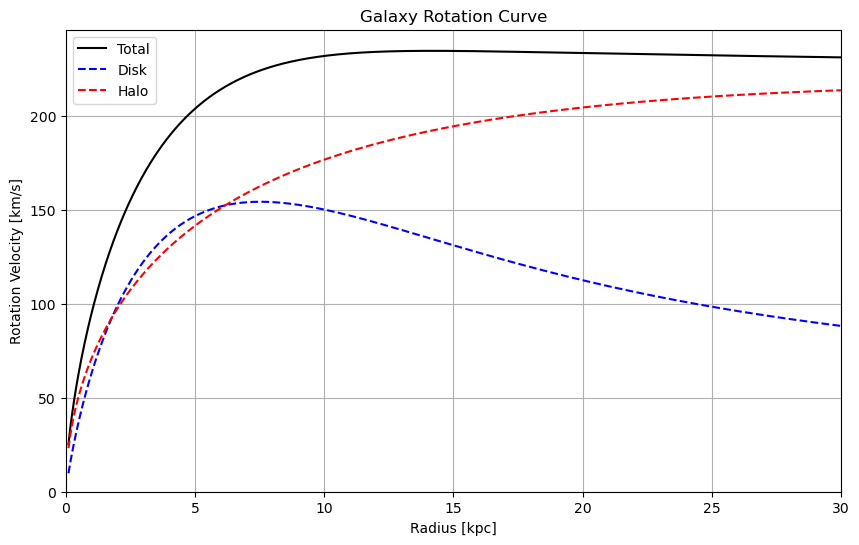

In [22]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(r.to(u.kpc).value, v_total.to(u.km/u.s).value, 'k-', label='Total')
plt.plot(r.to(u.kpc).value, v_disk.to(u.km/u.s).value, 'b--', label='Disk')
plt.plot(r.to(u.kpc).value, v_halo.to(u.km/u.s).value, 'r--', label='Halo')

# Customize the plot
plt.xlabel('Radius [kpc]')
plt.ylabel('Rotation Velocity [km/s]')
plt.title('Galaxy Rotation Curve')
plt.legend()
plt.grid(True)
plt.xlim(0, 30)
plt.ylim(0, None)

# Save the plot
plt.savefig('rotation_curve.png', dpi=300, bbox_inches='tight')
plt.show()